In [1]:
# Import libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


***Data Exploration & Visualization***

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

--- First 5 Rows of Training Data ---
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1  

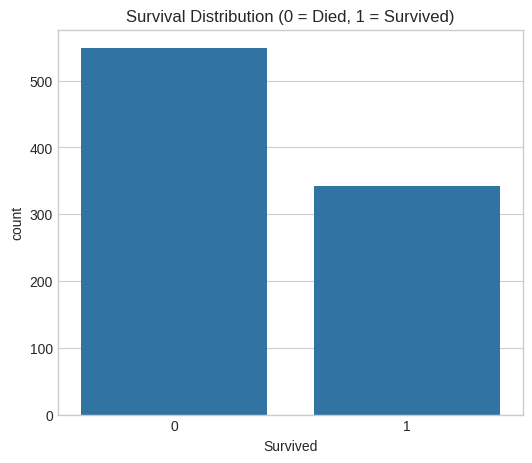

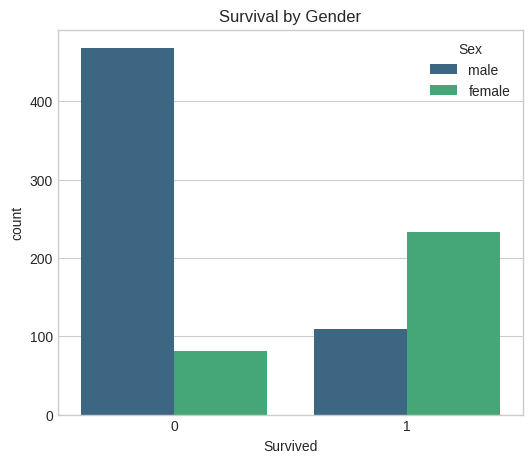

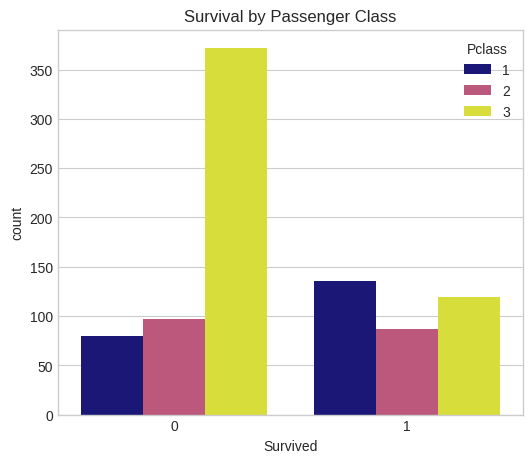

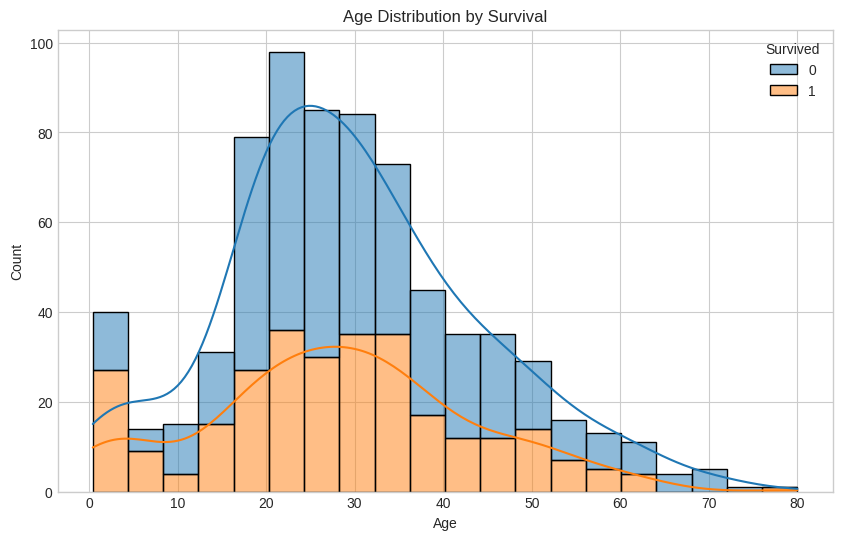

In [2]:
# Load the training and testing data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("--- Training Data Info ---")
train_df.info()
print("\n--- First 5 Rows of Training Data ---")
print(train_df.head())

# Let's start visualizing the most important relationships

# How many survived vs. died? (0 = No, 1 = Yes)
plt.figure(figsize=(6, 5))
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Distribution (0 = Died, 1 = Survived)')
plt.show()

# Survival by Gender
plt.figure(figsize=(6, 5))
sns.countplot(x='Survived', hue='Sex', data=train_df, palette='viridis')
plt.title('Survival by Gender')
plt.show()

# Survival by Passenger Class
plt.figure(figsize=(6, 5))
sns.countplot(x='Survived', hue='Pclass', data=train_df, palette='plasma')
plt.title('Survival by Passenger Class')
plt.show()

# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', hue='Survived', kde=True, multiple='stack')
plt.title('Age Distribution by Survival')
plt.show()

***Data Cleaning***

In [3]:
# Save PassengerId for the submission file later
test_passenger_ids = test_df['PassengerId']

# Combine train and test data for consistent cleaning
# We drop 'Survived' from the training set for now
train_labels = train_df['Survived']
combined_df = pd.concat([train_df.drop('Survived', axis=1), test_df], axis=0)

print(f"Combined DataFrame shape: {combined_df.shape}")
print("\n--- Missing Values Before Cleaning ---")
print(combined_df.isnull().sum())

# --- Handle Missing Values ---

# Age: Fill missing ages with the median age of their passenger class
median_age = combined_df.groupby('Pclass')['Age'].transform('median')
combined_df['Age'].fillna(median_age, inplace=True)

# Embarked: Fill the two missing values with the most common port (mode)
mode_embarked = combined_df['Embarked'].mode()[0]
combined_df['Embarked'].fillna(mode_embarked, inplace=True)

# Fare: Fill the one missing fare in the test set with the median
median_fare = combined_df['Fare'].median()
combined_df['Fare'].fillna(median_fare, inplace=True)

# Cabin: This column has too many missing values, so we'll drop it for this model
combined_df.drop('Cabin', axis=1, inplace=True)

print("\n--- Missing Values After Cleaning ---")
print(combined_df.isnull().sum())

Combined DataFrame shape: (1309, 11)

--- Missing Values Before Cleaning ---
PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

--- Missing Values After Cleaning ---
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


/tmp/ipython-input-2995581926.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Age'].fillna(median_age, inplace=True)
/tmp/ipython-input-2995581926.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

***Feature Engineering***

In [4]:
# --- Convert Categorical Features to Numbers ---

# Sex: Convert 'male' to 0 and 'female' to 1
combined_df['Sex'] = combined_df['Sex'].map({'male': 0, 'female': 1})

# Embarked: Use one-hot encoding to create numerical columns for each port
embarked_dummies = pd.get_dummies(combined_df['Embarked'], prefix='Embarked')
combined_df = pd.concat([combined_df, embarked_dummies], axis=1)

# --- Create New Features ---

# FamilySize: Combine SibSp (siblings/spouses) and Parch (parents/children)
combined_df['FamilySize'] = combined_df['SibSp'] + combined_df['Parch'] + 1

# IsAlone: A simple feature to check if the passenger was alone
combined_df['IsAlone'] = (combined_df['FamilySize'] == 1).astype(int)

# --- Final Cleanup ---
# Drop columns that are no longer needed for the model
columns_to_drop = ['Name', 'Ticket', 'Embarked', 'PassengerId']
combined_df.drop(columns_to_drop, axis=1, inplace=True)

print("\n--- Data After Feature Engineering ---")
print(combined_df.head())


--- Data After Feature Engineering ---
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0       3    0  22.0      1      0   7.2500       False       False   
1       1    1  38.0      1      0  71.2833        True       False   
2       3    1  26.0      0      0   7.9250       False       False   
3       1    1  35.0      1      0  53.1000       False       False   
4       3    0  35.0      0      0   8.0500       False       False   

   Embarked_S  FamilySize  IsAlone  
0        True           2        0  
1       False           2        0  
2        True           1        1  
3        True           2        0  
4        True           1        1  


***Model Building***

In [5]:
# Split the data back into training and testing sets
train_len = len(train_df)
X_train_final = combined_df[:train_len]
X_test_final = combined_df[train_len:]
y_train_final = train_labels

print(f"Training features shape: {X_train_final.shape}")
print(f"Test features shape: {X_test_final.shape}")

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_final, y_train_final, test_size=0.2, random_state=42
)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

print("\n✅ Model trained successfully!")

Training features shape: (891, 11)
Test features shape: (418, 11)

✅ Model trained successfully!


***Model Evaluation***

Validation Accuracy: 0.8101 (81.01%)

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179


--- Confusion Matrix ---


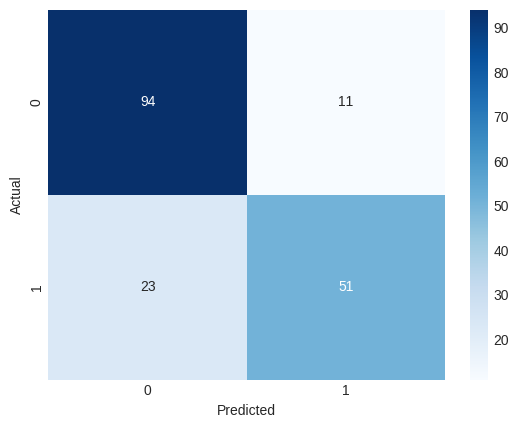

In [6]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f} ({accuracy:.2%})")

# Print a detailed classification report
print("\n--- Classification Report ---")
print(classification_report(y_val, y_pred))

# Show the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

***Submission***

In [7]:
# Make predictions on the final test data
test_predictions = model.predict(X_test_final)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': test_predictions
})

# Save the submission file
submission_df.to_csv('titanic_submission.csv', index=False)

print("✅ Submission file 'titanic_submission.csv' created successfully!")
print("\n--- First 5 rows of submission file ---")
print(submission_df.head())

✅ Submission file 'titanic_submission.csv' created successfully!

--- First 5 rows of submission file ---
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
